In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# wget https://huggingface.co/huseinzol05/nemo-titanet_large/raw/main/model_config.yaml -O titanl_model_config.yaml
# wget https://huggingface.co/huseinzol05/nemo-titanet_large/resolve/main/model_weights.ckpt -O titan_model.ckpt

In [3]:
import yaml

config = 'titanl_model_config.yaml'
with open(config) as stream:
    try:
        d = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise ValueError('invalid yaml')

In [4]:
d['decoder']['num_classes'] = 2
d['decoder']['angular'] = False

In [5]:
with open('is-clean.yaml', 'w') as fopen:
    yaml.dump(d, fopen)

In [6]:
from malaya_speech.utils import nemo_featurization
from malaya_speech.nemo import conv_asr
import malaya_speech
from malaya_speech.utils.padding import sequence_1d
from malaya_boilerplate.torch_utils import to_tensor_cuda, to_numpy
import numpy as np
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        preprocessor = d['preprocessor'].copy()
        preprocessor_target = (preprocessor.pop('_target_', None) or preprocessor.pop('cls', None)).split('.')[-1]
        if 'params' in preprocessor:
            preprocessor = preprocessor['params']

        encoder = d['encoder'].copy()
        encoder_target = (encoder.pop('_target_', None) or encoder.pop('cls', None)).split('.')[-1]
        if 'params' in encoder:
            encoder = encoder['params']

        decoder = d['decoder'].copy()
        decoder_target = (decoder.pop('_target_', None) or decoder.pop('cls', None)).split('.')[-1]
        if 'params' in decoder:
            decoder = decoder['params']

        self.preprocessor = getattr(nemo_featurization, preprocessor_target)(**preprocessor)
        self.encoder = getattr(conv_asr, encoder_target)(**encoder)
        self.decoder = getattr(conv_asr, decoder_target)(**decoder)
    
    def forward(self, inputs):
        """
        Vectorize inputs.

        Parameters
        ----------
        inputs: List[np.array]
            List[np.array] or List[malaya_speech.model.frame.Frame].
        """

        cuda = next(self.parameters()).is_cuda
        inputs, lengths = sequence_1d(
            inputs, return_len=True
        )
        inputs = to_tensor_cuda(torch.Tensor(inputs.astype(np.float32)), cuda)
        lengths = to_tensor_cuda(torch.Tensor(lengths), cuda)
        o_processor = self.preprocessor(inputs, lengths)
        o_encoder = self.encoder(*o_processor)
        return self.decoder(*o_encoder)

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [7]:
model = Model()

In [8]:
!ls -lh titanetl-is-clean-32

total 1.5G
-rw-r--r-- 1 husein husein 254M Feb  22 13:37 'model-epoch=00-step=1000000.ckpt'
-rw-r--r-- 1 husein husein 254M Feb  21 16:48 'model-epoch=00-step=10000.ckpt'
-rw-r--r-- 1 husein husein 254M Feb  22 13:46 'model-epoch=00-step=1010000.ckpt'
-rw-r--r-- 1 husein husein 254M Feb  21 16:59 'model-epoch=00-step=20000.ckpt'
-rw-r--r-- 1 husein husein 254M Feb  21 17:07 'model-epoch=00-step=30000.ckpt'
-rw-r--r-- 1 husein husein 254M Feb  22 13:28 'model-epoch=00-step=990000.ckpt'


In [9]:
current_model_dict = model.state_dict()
loaded_state_dict = torch.load('titanetl-is-clean-32/model-epoch=00-step=1000000.ckpt', map_location=torch.device('cpu'))['state_dict']
new_state_dict = {k:v if v.size() == current_model_dict[k].size() else current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [10]:
torch.save(model.state_dict(), 'is-clean-titanet-l.pt')

In [11]:
model.load_state_dict(torch.load('is-clean-titanet-l.pt', map_location='cpu'))

<All keys matched successfully>

In [12]:
_ = model.eval()

In [13]:
from glob import glob
import random

vctk = random.sample(glob('/home/husein/ssd2/wav48_silence_trimmed/*/*.flac'), 10000)

In [14]:
y, _ = malaya_speech.load(vctk[0])
noise, _ = malaya_speech.load('speech/noise/noise-free-sound-0322.wav')
# y = malaya_speech.augmentation.waveform.add_noise(
#     y, noise, factor=random.uniform(0.3, 0.7))

In [15]:
frames = malaya_speech.generator.frames(y, 100, 16000, False)

In [16]:
len(frames)

31

In [17]:
%%time

o = model([f.array for f in frames])[0]

CPU times: user 1.48 s, sys: 326 ms, total: 1.81 s
Wall time: 181 ms


In [18]:
from malaya_speech.utils.activation import softmax

In [19]:
(softmax(o.detach().numpy(), axis = 1)[:,1] > 0.2).mean()

0.4838709677419355

In [20]:
o.detach().numpy().argmax(axis = -1).mean()

0.45161290322580644

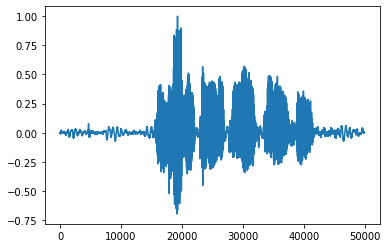

In [21]:
import matplotlib.pyplot as plt

plt.plot(y)

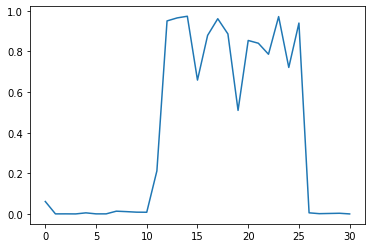

In [22]:
plt.plot(softmax(o.detach().numpy(), axis = 1)[:,1])

In [23]:
import IPython.display as ipd

ipd.Audio(y, rate = 16000)

In [24]:
from malaya_boilerplate.huggingface import upload_dict

In [25]:
files_mapping = {'is-clean-titanet-l.pt': 'model_weights.ckpt',
                 'is-clean.yaml': 'model_config.yaml',}
upload_dict(model = 'nemo-is-clean-titanet_large', files_mapping = files_mapping, username = 'huseinzol05')

/home/husein/.local/lib/python3.8/site-packages/huggingface_hub/hf_api.py:101: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.10. Pass `repo_id` instead.
  warnings.warn(
<class 'requests.exceptions.HTTPError'> (Request ID: Root=1-63f5ac7f-233ea130485fea9501a6ca05)

You already created this model repo - You already created this model repo
